# Facebook's Prophet 
The Prophet package aims to provide a simple, automated approach to do time series anaysis and predictions. The package employs an easily interpreted, three component additive model whose Bayesian posterior is sampled using STAN, which is a state-of-the-art platform for statistical modeling and high-performance statistical computation. 

Prophet is best suited for business-like time series with clear seasonality and where you know important business dates and events beforehand. Prophet is also quite easy to tune with its understandable hyper-parameters. In addition, it is extendable, so if you need to add additional regressors, seasonalities or special events you can do so easily.

In [1]:
import pandas as pd
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn import preprocessing
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pd.set_option('display.max_row', 100) 


# Dataset

Here is a dataset made by combining real world data from the Norwegian road authorities and the Norwegian Meteorological Institute. We have gathered some data measuring people using their bikes to and from work. In addition, the dataset is augmented with historical rainfall and temperature data. 

Download the dataset at 
https://github.com/pixelbakker/datasets/blob/master/bikerides_day.csv

In [2]:
PATH = "/content/bikerides_day.csv"

bikerides = pd.read_csv(PATH, error_bad_lines=False, encoding= 'unicode_escape', delimiter=',')
bikerides["Date"] = pd.to_datetime(bikerides["Date"])
bikerides.head()

,Date,Volume,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8


Prophet is expecting columns to have specific names, "ds" for the temporal part and "y" for the value part. Rename the columns to Prophet scheme.


In [3]:
bikerides.columns = ['ds', 'y', 'rain', 'temp']
bikerides.head(1)

,ds,y,rain,temp
0,2016-11-17,933.0,9.0,2.1


In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

In weekends people are not commuting to work. 

In [5]:
# Removing weekends
bikerides.set_index('ds', inplace=True)
bikerides = bikerides[bikerides.index.dayofweek < 5].reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

For time-series it’s often useful to do some form of power transform of the data to stabilise variance and make the data more normal distribution-like. 

We can use a Box Cox transformation that evaluates a set of lambda coefficients ($\lambda$) and selects the value that achieves the best approximation of normality. 

In [6]:
# Apply Box-Cox Transform and save the lambda for later inverse.
bikerides['y'], lam = boxcox(bikerides['y'])
print('Lambda is:', lam)

fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

Lambda is: 0.45166936452584744


## Math formula

Prophet sees forecasting mainly as a curve fitting exercise using probabilistic techniques and inspiration from generalised additive models. 

To model time series Prophet separate the signal into the following additive components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_t$$

$g(t)$ is the trend function which models non-periodic changes using either a non linear saturation growth model or piecewise linear regression model. You can configure this using parameters.

$s(t)$ is the seasonal functional (yearly, weekly and daily) which models the periodic changes in the value of the time series. This component is modelled using a Fourier transform and if you want you can add your own seasonalities.

$h(t)$ represents the function for modelling holidays and special impact events. You can add your own set of custom holidays and special events.

$\epsilon_t$ is the error/noise term which is assumed to be normally distributed.

In [7]:
m = Prophet()
m.fit(bikerides)
 
# create a data frame holding dates for our forecast. 
future = m.make_future_dataframe(periods=180, freq='D')
forecast = m.predict(future)
print(forecast.head())
print(forecast.info())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      trend  ...  multiplicative_terms_upper       yhat
0 2016-11-17  71.866777  ...                         0.0  62.385470
1 2016-11-18  71.865203  ...                         0.0  57.659348
2 2016-11-21  71.860481  ...                         0.0  66.472226
3 2016-11-22  71.858907  ...                         0.0  67.087389
4 2016-11-23  71.857333  ...                         0.0  65.692016

[5 rows x 19 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          1089 non-null   datetime64[ns]
 1   trend                       1089 non-null   float64       
 2   yhat_lower                  1089 non-null   float64       
 3   yhat_upper                  1089 non-null   float64       
 4   trend_lower                 1089 non-null   float64       
 5   trend_upp

Plotting with Prophet built-in method, you can add change-points where the trend model is shifting.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



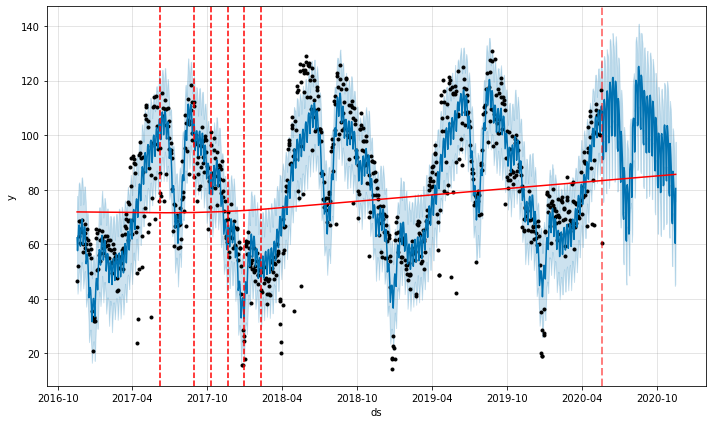

In [8]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('180 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

List all the change points in the model.

In [9]:
deltas = m.params['delta'].mean(0)
cp = pd.DataFrame(m.changepoints)
cp['deltas'] = deltas

fig = go.Figure()
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))

Plot all the components that make up the model: trend, different seasonalities and holidays.

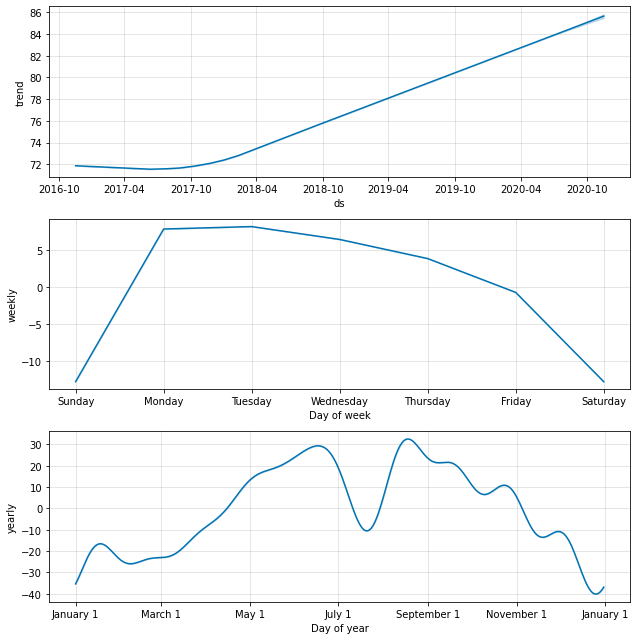

In [10]:
fig = m.plot_components(forecast)

# Cross validation

The Prophet library makes it possible to divide our historical data into training data and testing data for cross validation. The main concepts for cross validation with Prophet are:

$\bullet$ Training data (initial): The amount of data set aside for training. The parameter in the API is called initial.

$\bullet$ Horizon: The data set aside for validation. If you don’t define a period the model will be fitted with Horizon/2.

$\bullet$ Cutoff (period): a forecast is made for every observed point between cutoff and cutoff + horizon.

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

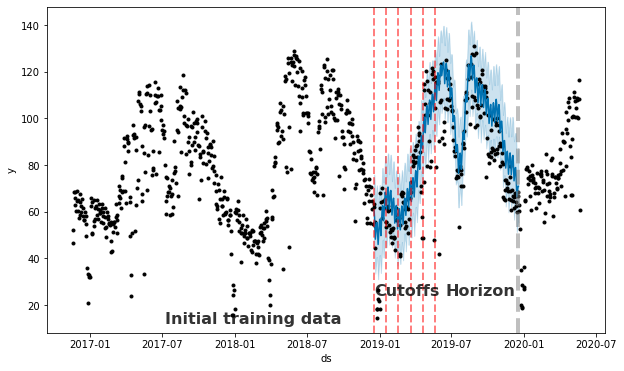

In [11]:
# Fit the model with two years of data and define a horizon of 365 days forcasting per month
df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'], df_cv['yhat_upper'], color='#0072B2', alpha=0.2)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2017-07-07'),y=12, s='Initial training data', color='black', fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2018-12-17'),y=24, s='Cutoffs', color='black', fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('180 days'),y=24, s='Horizon', color='black', fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4, alpha=0.5, ls='--')

Getting the performance metrics

In [12]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,361.154786,19.004073,14.035482,0.572952,0.134953,0.68
1,37 days,364.024873,19.079436,14.306714,0.577503,0.144366,0.68
2,38 days,364.375205,19.088615,14.348343,0.577885,0.144366,0.68
3,39 days,365.903155,19.128595,14.515123,0.580992,0.144366,0.68
4,42 days,377.162953,19.420684,15.049206,0.590981,0.150619,0.64


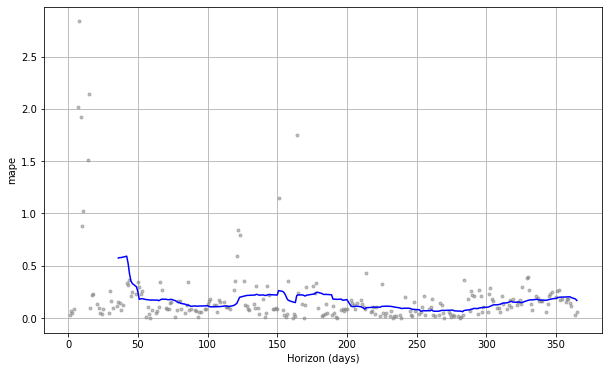

In [13]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [14]:
df_p.mean()

horizon     199 days 23:35:10.344827586
mse                             203.797
rmse                            13.5165
mae                             10.9163
mape                           0.161311
mdape                          0.103983
coverage                       0.785862
dtype: object

add two utility functions so we don’t need to change data all over the place if we want to test different cross validation set-ups. 

In [15]:
def getPerformanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='730 days', period='31 days', horizon='365 days')

Prophet has several ways of adding holidays and special events. The easiest and most convenient one is to use the built-in national holidays.

In [16]:
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)

# List the holiday names
m.train_holiday_names

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0                    Søndag
1           Første påskedag
2           Arbeidernes dag
3           Første pinsedag
4            Første juledag
5         Første nyttårsdag
6              Grunnlovsdag
7             Andre juledag
8              Skjærtorsdag
9                Langfredag
10           Andre påskedag
11    Kristi himmelfartsdag
12           Andre pinsedag
dtype: object

In [17]:
future = m.make_future_dataframe(periods=180, freq='D')
forecast = m.predict(future)

fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

add some additional dates for the model to take into account.

For the Ascension Day date I’ve set the upper_window. This means that the effect of the day will spill over by one day so that we can capture the effect on Friday also. For the Christmas dates I’ve set the lower window so that we can catch the day before Christmas Eve in Norway and the upper window to catch the whole Christmas vacation that many Norwegians have. 

In [18]:
ascensionday = pd.DataFrame({
  'holiday': 'AscensionDay',
  'ds': pd.to_datetime(['2019-05-30']),
  'lower_window': 0,
  'upper_window': 1,
})

christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})

holidays = pd.concat((ascensionday, christmas))

m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
getPerformanceMetrics(m).mean()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

horizon     201 days 00:00:00
mse                   123.944
rmse                  11.0681
mae                   8.46612
mape                 0.112679
mdape               0.0830702
coverage             0.768979
dtype: object

# Adding extra regressors

We can add the rain and temperature data as extra regressors to the model.

In [20]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
m.add_regressor('rain')
m.add_regressor('temp')
m.fit(bikerides)

future = m.make_future_dataframe(periods=0, freq='D')
future = future.merge(bikerides, on='ds')
forecast = m.predict(future)

fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
getPerformanceMetrics(m).mean()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

horizon     201 days 00:00:00
mse                   90.6775
rmse                  9.49015
mae                   6.87276
mape                0.0926062
mdape               0.0615491
coverage             0.794497
dtype: object

# Tuning hyperparameters

In [22]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(holidays=holidays, **param_dict)
    m.add_country_holidays(country_name='NO')
    m.add_regressor('rain')
    m.add_regressor('temp')
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p


#'changepoint_range': [0.6, 0.7, 0.75, 0.8, 0.9],
#'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],
#'seasonality_prior_scale':[0.5, 1.0, 2.5, 5],
#'holidays_prior_scale':[1.0, 5.0, 10.0, 15.0],
#'yearly_seasonality':[5, 10, 15, 20],
#'weekly_seasonality':[5, 10, 15, 20],

pd.set_option('display.max_colwidth', None)
param_grid = {  'changepoint_prior_scale': [0.01],
                'changepoint_range': [0.3],
                'holidays_prior_scale':[1.0],
                'seasonality_prior_scale':[0.5],
                'yearly_seasonality':[20],
                'weekly_seasonality':[5],
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
results = []

params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(bikerides,  metrics, param_dict, parallel="processes")
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]


 The best param combination is {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.3, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.5, 'yearly_seasonality': 20.0, 'weekly_seasonality': 5.0}


horizon    365 days 00:00:00
rmse                 9.31943
mae                  6.89089
mape               0.0916316
mdape              0.0690817
dtype: object

get the best parameters

In [23]:
m = Prophet(holidays=holidays, changepoint_prior_scale=0.01,
            changepoint_range=0.8,
            seasonality_prior_scale=0.5,
            holidays_prior_scale=1.0,
            yearly_seasonality=20,
            weekly_seasonality=5,
            seasonality_mode='additive')

m.add_country_holidays(country_name='NO')
# Adding the extra weather regressors
m.add_regressor('rain')
m.add_regressor('temp')
    
m.fit(bikerides)
getPerformanceMetrics(m).mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

horizon     201 days 00:00:00
mse                   85.1918
rmse                  9.20033
mae                     6.871
mape                0.0888604
mdape               0.0678401
coverage             0.784067
dtype: object

Plotting and verifying the whole model

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], name='Yearly',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['weekly'], name='Weekly',))
fig.show()

To check that the model's forecast is actually the sum of its components

In [25]:
# Let's get the sum of yhat (the prediction)
sum_yhat = forecast['yhat'].sum()
print('Forecast sum is:', sum_yhat)

sum_components = forecast['trend'].sum()+forecast['yearly'].sum()+ forecast['weekly'].sum()+forecast['holidays'].sum()+ forecast['extra_regressors_additive'].sum()
print('Sum of components is:', sum_components)
print('The model is equal to the sum of its components:', sum_yhat.round()==sum_components.round())

Forecast sum is: 71678.19563946323
Sum of components is: 71678.19563946324
The model is equal to the sum of its components: True


# Making an actual forecast

In [26]:
# Make a zero days forecast just for plotting
future = m.make_future_dataframe(periods=0, freq='D')
future = future.merge(bikerides, on='ds')
forecast = m.predict(future)

# Transform back to reality from Box Cox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
bikerides['y'] = inv_boxcox(bikerides['y'], lam)

# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.show()

# References

https://futurice.com/blog/business-forecasting-with-facebook-prophet

https://facebook.github.io/prophet/docs/quick_start.html

https://www.microprediction.com/blog/prophet